In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.table import Table, vstack, hstack
from astropy.utils.data import download_file
from astropy.time import Time
from astropy.timeseries import TimeSeries
import sunpy.timeseries as ts  
import netCDF4
import xarray as xr

from bs4 import BeautifulSoup
from urllib.request import HTTPError


base_url = "http://mkwc.ifa.hawaii.edu/archive/wx/cfht/"

In [4]:
# header from base_url
tables = []

for i in range(1991, 2021):#1991, 2021
    # the year 2003 and 2009 skipp it now
    #if i == 2003:
    #    continue
    print('Downloading year:', i)
    # raw_table = open(download_file(base_url + 'cfht-wx.{0}.dat'.format(i), cache=True)).read()
    
        #in 2009, there is a line that looks like "12 233 3.49 16 617.9"
    if i == 2009:
        with open(download_file(base_url + 'cfht-wx.{0}.dat'.format(i), cache=False), 'r') as file:
            filename = "cfht_2009.txt"
            file.seek(0)
            lines = file.readlines()
            with open(filename, 'w') as file1:
                for i, line in enumerate(lines):
                    if i != 75411:
                        file1.write(line)
                        #print('{0}', line)
                file1.truncate()
            with open(filename, 'r') as file1:
                raw_table = file1.read()

    #in 2017, in line 497145, an 11. column appears, filled with the value 0.00
    elif i == 2017:
        with open(download_file(base_url + 'cfht-wx.{0}.dat'.format(i), cache=False), 'r') as file:
            filename = "cfht_2017.txt"
            file.seek(0)
            lines = file.readlines()
            with open(filename, 'w') as file2:
                for i, line in enumerate(lines):
                    if i < 497145:
                        file2.write(line)
                    else:
                        new_string = lines[i]
                        new_string_cut = new_string[0:(len(new_string)-5)]
                        str_assembled = (new_string_cut + '\n')
                        #print(str_assembled)
                        file2.write(str_assembled)
                with open(filename, 'r') as file2:
                    raw_table = file2.read()
    else:
        with open(download_file(base_url + 'cfht-wx.{0}.dat'.format(i), cache=True), 'r') as file:
            raw_table = file.read()
    
    #table = Table(names=('year', 'month', 'day', 'hour', 'min', 'wind_speed(kts)', 'wind_direction(dec)', 'temperature(C)', 
    #  'relative_humidity(%)', 'pressure(mb)'), dtype=('int64', 'int64','int64', 'int64','int64','int64','float64','float64', 'float64', 'float64'))        

    table = Table.read(raw_table, format='ascii.no_header', delimiter=' ')

        
            
        
    #some Tables have column 10, which is the pressure
    # if 'col10' in table.colnames and not table['col10'].dtype in (float, 'float64'):
    #    column = pd.Series(table['col10'].data)
    #    mask = column.str.contains(' ') | (column == 'N/A') | (column == '?')
    #    column[mask] = np.nan
    #    table['col10'] = column
    #    table['col10'] = table['col10'].astype(float)
        
    tables.append(table)

In [5]:
#to remove the column 11 in year 2018
tables[27].remove_column('col11')
tables[27]

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
int64,int64,int64,int64,int64,int64,float64,float64,int64,float64
2018,1,1,0,0,27,23.0,-0.57,45,617.7
2018,1,1,0,1,27,27.0,-0.59,45,617.7
2018,1,1,0,2,26,24.0,-0.58,45,617.7
2018,1,1,0,3,27,21.0,-0.6,45,617.7
2018,1,1,0,4,26,22.0,-0.6,45,617.7
2018,1,1,0,5,26,22.0,-0.6,45,617.7
2018,1,1,0,6,27,21.0,-0.6,45,617.7
2018,1,1,0,7,27,25.0,-0.61,45,617.7
2018,1,1,0,8,25,26.0,-0.63,45,617.7


In [8]:
columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8','col9']
labels = ['year', 'month', 'day', 'hour', 'min', 'wind_speed(kts)', 'wind_direction(dec)', 'temperature(C)', 
          'relative_humidity(%)']

for k in range(0, 30):
    for col_ind, label in zip(columns, labels):
        if label not in tables[k].colnames:
            tables[k].rename_column(col_ind, label)
    if 'col10' in tables[k].colnames: #some Tables have column 10, which is the pressure
        tables[k].rename_column('col10', 'pressure (mb)')


In [12]:
# takes around 10 minutes on my Sony Vaio (depends..)

for table in tables: 
    try:
        if 'year' in table.colnames: 
            time_strings = ["{0}-{1}-{2}T{3}:{4}:00"
                            .format(row['year'], row['month'], row['day'], 
                                    row['hour'], row['min']).replace(',', '').replace('202013', '2013') #there are commas sometimes
                            for row in table]
            times = Time(time_strings, format='isot') #use isot to simplify inreading of textfile
            table['times'] = times
        
    except ValueError:
        pass


In [41]:
#takes around 60 min!!
#save tables to a text file, which can be read instead of running all the code above

from tabulate import tabulate

filename = 'CFHT_1991_to_2018_v2.txt'

with open(filename, 'w') as file:
    for i, table in enumerate(tables):
        file.write(tabulate(tables[i]))


In [62]:
#function to convert a parameter (e.g. PRESSURE) to sunpy timeseries and plot data

#def convert__to_sunpy_ts('downsampled_Pressure_hourly.csv', '1991_2018_CFHT_Pressure_hourly_mean.pdf',
#    'pressure (mb)', '1h')

def convert_to_sunpy_ts(filename, parameter, time_downsample):

    timeseries = []
    downsampled = []

    if parameter == 'pressure (mb)':
        for i, table in enumerate(tables):
            if parameter in table.colnames: 
                print(i)
                timeseries.append(ts.TimeSeries(hstack([table['times'], table[parameter]])))
                downsampled.append(timeseries[i-9].data.resample(time_downsample).mean()) #1m for monthly mean, 1d for daily mean, 1h for hourly mean
        df = pd.concat(downsampled)
        
    elif parameter == 'relative_humidity(%)':
        for i, table in enumerate(tables):
            # filter values smaller than 0 and greater than 100
            mask = (table['relative_humidity(%)'] < 100) | (table['relative_humidity(%)'] > 0)
            table[mask]
            timeseries.append(ts.TimeSeries(hstack([table['times'], table['relative_humidity(%)']])))
            downsampled.append(timeseries[i].data.resample(time_of_mean).mean())
    # save to csv
    df.to_csv(filename)

    return df


In [39]:
# fig_name = '1991_2018_CFHT_Pressure_hourly_mean.pdf'
# y_axis = "pressure(mb)"
#ylim = (0, 100)

#, bool y_lim, ylim
def plot_timeseries(df, figname, y_title, plot_title = '', y_lim = False):

    plt.plot(df, 'bo', markersize = '2')
    plt.title(plot_title)
    if y_lim == True:
        plt.ylim(y_lim)

    #change y label and fig name!!

    plt.ylabel(y_title)

    plt.xlabel("Time (s)")
    plt.savefig(fig_name)



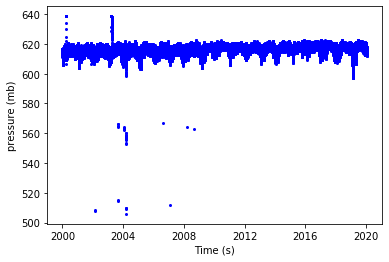

In [40]:
df_test = convert_to_sunpy_ts('downsampled_Pressure_hourly.csv','pressure (mb)', '1h')
plot_timeseries(df_test, '1991_2018_CFHT_Pressure_hourly_mean.pdf', 'pressure (mb)')

In [43]:
#open NETCDF file
#ds_RH_test = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/RH/Era5_test_RH_2009_2018.nc')
ds_RH = xr.open_dataset('/home/caroline/hulk/Astroclimate/cds_data_ERA5/RH/Era5_2009to2018_RH_600hPa.nc')

# define grid location (lon/lat) of Mauna Kea
ds_MaunaKea_RH = ds_RH.sel(longitude=204.53,latitude= 19.83,method='nearest')


In [49]:
ds_MaunaKea_RH.time[3]

<xarray.DataArray 'time' ()>
array('2009-01-01T03:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude  float32 204.5
    latitude   float32 19.75
    time       datetime64[ns] 2009-01-01T03:00:00
Attributes:
    long_name:  time

In [54]:
# resample ERA5 data 

# hourly, do nothing
#ds_MaunaKea_RH_resampled_hourly = ds_MaunaKea_RH

ds_MaunaKea_RH_resampled_daily = ds_MaunaKea_RH.resample(time = '1d').mean()

# ds_MaunaKea_RH_resampled_monthly = ds_MaunaKea_RH.resample(time = '1m').mean()

# convert RELATIVE HUMIDITY to sunpy timeseries
df_RH = convert_to_sunpy_ts('downsampled_Pressure_hourly.csv','relative humidity(%)', '1d')

In [58]:
ds_MaunaKea_RH_resampled_daily.time[2]

<xarray.DataArray 'time' ()>
array('2009-01-03T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time       datetime64[ns] 2009-01-03
    latitude   float32 19.75
    longitude  float32 204.5

In [61]:
df_RH = convert_to_sunpy_ts('downsampled_RH_CFHT_hourly.csv','relative humidity(%)', '1d')



UnboundLocalError: local variable 'df' referenced before assignment

In [85]:
#not needed anymore

#convert RELATIVE HUMIDITY to sunpy timeseries

import sunpy.timeseries as ts  

#change parameters for every file
filename = 'downsampled_RH_daily_mean.csv'
time_of_mean = '1d'

timeseries = []
downsampled = []

for i, table in enumerate(tables):#tables_to2000
    # filter values smaller than 0 and greater than 100
    mask = (table['relative_humidity(%)'] < 100) | (table['relative_humidity(%)'] > 0)
    table[mask]
    timeseries.append(ts.TimeSeries(hstack([table['times'], table['relative_humidity(%)']])))
    downsampled.append(timeseries[i].data.resample(time_of_mean).mean()) #1m for monthly mean, 1d for daily mean, 1h for hourly mean


df = pd.concat(downsampled)

# save to csv
df.to_csv(filename)


In [53]:
#short_variable_name = 'r'
#ylabel = "Relative Humidity (%)"
#plot_title = 'Relative humidity, Era 5 test, daily'
# ylim = (0, 100)

def plot_ERA5_and_data(df_data, df_ERA5, short_variable_name, fig_name, ylabel, plot_title = '', ylim = False):

    # this function plots observational data from CFHT and data from ERA 5
    plt.plot(df_data, 'bo', markersize = '2', label = 'CFHT') #, legend = 'CFHT'
    
    plt.plot(df_ERA5['time'],df_ERA5[short_variable_name], 'ro', markersize = '2', label = 'ERA 5') 

    plt.title(plot_title)

    plt.ylabel(ylabel)
    plt.xlabel("Time (s)")
    if ylim == True:
        plt.ylim(ylim)
        
    #plt.xlim(('2012-01-01', '2018-01-01')) why does this not work??
    plt.legend()

    plt.savefig(fig_name)
    #plt.show()


In [ ]:
plot_ERA5_and_data(df_data, df_ERA5, short_variable_name, fig_name, ylabel, plot_title = 'Relative humidity, Era 5, daily', ylim = (0, 100))

In [42]:
#convert TEMPERATURE to timeseries
import sunpy.timeseries as ts  

#change parameters for every file
filename = 'downsampled_Temperatur_hourly_mean.csv'


timeseries = []
downsampled = []

#tables_to2000 = []
#tables_to2000[:10] = tables[:10]



for i, table in enumerate(tables):#tables_to2000
    timeseries.append(ts.TimeSeries(hstack([table['times'], table['temperature(C)']])))
    downsampled.append(timeseries[i].data.resample('1m').mean()) #1m for monthly mean, 1d for daily mean, 1h for hourly mean
df_T = pd.concat(downsampled)

# save to csv
#df.to_csv(filename)

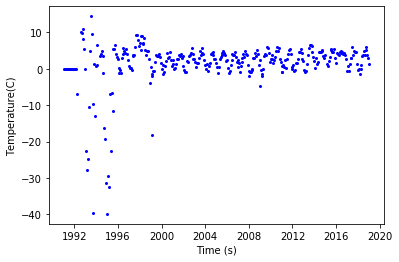

In [43]:
# save to csv
df_T.to_csv(filename)
#and plot
plt.plot(df_T, 'bo', markersize = '2')
#ax.set_ylim([0, 100]) #error "name ax is not defined" appears"

#change y label and fig name!!
fig_name = '1991_2018_CFHT_Temperature_monthly_mean.pdf'
plt.ylabel("Temperature(C)")

plt.xlabel("Time (s)")
plt.savefig(fig_name)

In [264]:
import sunpy.timeseries as ts  
    
# put time and RH into one table
#ts_RH_append = ([tables[i]['times'], tables[i]['RH(%)']])
#for i in range (0,2001-1991):
    #ts_RH.append = hstack([tables[i]['times'], tables[i]['RH(%)']])
#    ts_RH = Table(names=['time_object', 'RH(%)'], data=[tables[i]['times'], tables[i]['RH(%)']])
#    print(i)
#    tables_RH.append(ts_RH)

#ts_RH_1991 = ts.TimeSeries(hstack([tables[0]['times'], tables[0]['RH(%)']]))
#ts_RH_1992 = ts.TimeSeries(hstack([tables[1]['times'], tables[1]['RH(%)']]))
#ts_RH_1993 = ts.TimeSeries(hstack([tables[2]['times'], tables[2]['RH(%)']]))
ts_RH_1994 = ts.TimeSeries(hstack([tables[3]['times'], tables[3]['RH(%)']]))
ts_RH_1995 = ts.TimeSeries(hstack([tables[4]['times'], tables[4]['RH(%)']]))
ts_RH_1996 = ts.TimeSeries(hstack([tables[5]['times'], tables[5]['RH(%)']]))
ts_RH_1997 = ts.TimeSeries(hstack([tables[6]['times'], tables[6]['RH(%)']]))
ts_RH_1998 = ts.TimeSeries(hstack([tables[7]['times'], tables[7]['RH(%)']]))
ts_RH_1999 = ts.TimeSeries(hstack([tables[8]['times'], tables[8]['RH(%)']]))
ts_RH_2000 = ts.TimeSeries(hstack([tables[9]['times'], tables[9]['RH(%)']]))




downsampled_dataframe_RH_1991 = ts_RH_1991.data.resample('1d').mean()
downsampled_dataframe_RH_1992 = ts_RH_1992.data.resample('1d').mean()
downsampled_dataframe_RH_1993 = ts_RH_1993.data.resample('1d').mean()
downsampled_dataframe_RH_1994 = ts_RH_1994.data.resample('1d').mean()
downsampled_dataframe_RH_1995 = ts_RH_1995.data.resample('1d').mean()
downsampled_dataframe_RH_1996 = ts_RH_1996.data.resample('1d').mean()
downsampled_dataframe_RH_1997 = ts_RH_1997.data.resample('1d').mean()
downsampled_dataframe_RH_1998 = ts_RH_1998.data.resample('1d').mean()
downsampled_dataframe_RH_1999 = ts_RH_1999.data.resample('1d').mean()
downsampled_dataframe_RH_2000 = ts_RH_2000.data.resample('1d').mean()


df3_daily = pd.concat([downsampled_dataframe_RH_1991, downsampled_dataframe_RH_1992, downsampled_dataframe_RH_1993, downsampled_dataframe_RH_1994,
                downsampled_dataframe_RH_1995, downsampled_dataframe_RH_1996, downsampled_dataframe_RH_1997, downsampled_dataframe_RH_1998, 
                 downsampled_dataframe_RH_1999, downsampled_dataframe_RH_2000])

plt.plot(df3_daily)

#downsampled_dataframe_RH_1991.plot()
#plt.show()

plt.xlabel("Time (s)")
plt.ylabel("Relative Humidity (%)")
plt.savefig('RH_1991_2000_daily_mean.pdf')

KeyError: 'times'

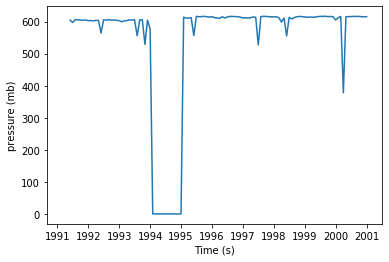

In [44]:
#start here!
#pressure diagram

import sunpy.timeseries as ts

tables_RH = []   
    
# put time and RH into one table
#ts_RH_append = ([tables[i]['times'], tables[i]['RH(%)']])
#for i in range (0,2001-1991):
    #ts_RH.append = hstack([tables[i]['times'], tables[i]['RH(%)']])
#    ts_RH = Table(names=['time_object', 'RH(%)'], data=[tables[i]['times'], tables[i]['RH(%)']])
#    print(i)
#    tables_RH.append(ts_RH)


ts_pr_1991 = ts.TimeSeries(hstack([tables[0]['times'], tables[0]['pressure(mb)']]))
ts_pr_1992 = ts.TimeSeries(hstack([tables[1]['times'], tables[1]['pressure(mb)']]))
ts_pr_1993 = ts.TimeSeries(hstack([tables[2]['times'], tables[2]['pressure(mb)']]))
ts_pr_1994 = ts.TimeSeries(hstack([tables[3]['times'], tables[3]['pressure(mb)']]))
ts_pr_1995 = ts.TimeSeries(hstack([tables[4]['times'], tables[4]['pressure(mb)']]))
ts_pr_1996 = ts.TimeSeries(hstack([tables[5]['times'], tables[5]['pressure(mb)']]))
ts_pr_1997 = ts.TimeSeries(hstack([tables[6]['times'], tables[6]['pressure(mb)']]))
ts_pr_1998 = ts.TimeSeries(hstack([tables[7]['times'], tables[7]['pressure(mb)']]))
ts_pr_1999 = ts.TimeSeries(hstack([tables[8]['times'], tables[8]['pressure(mb)']]))
ts_pr_2000 = ts.TimeSeries(hstack([tables[9]['times'], tables[9]['pressure(mb)']]))


downsampled_dataframe_pr_1991 = ts_pr_1991.data.resample('1m').mean()
downsampled_dataframe_pr_1992 = ts_pr_1992.data.resample('1m').mean()
downsampled_dataframe_pr_1993 = ts_pr_1993.data.resample('1m').mean()
downsampled_dataframe_pr_1994 = ts_pr_1994.data.resample('1m').mean()
downsampled_dataframe_pr_1995 = ts_pr_1995.data.resample('1m').mean()
downsampled_dataframe_pr_1996 = ts_pr_1996.data.resample('1m').mean()
downsampled_dataframe_pr_1997 = ts_pr_1997.data.resample('1m').mean()
downsampled_dataframe_pr_1998 = ts_pr_1998.data.resample('1m').mean()
downsampled_dataframe_pr_1999 = ts_pr_1999.data.resample('1m').mean()
downsampled_dataframe_pr_2000 = ts_pr_2000.data.resample('1m').mean()


df3 = pd.concat([downsampled_dataframe_pr_1991, downsampled_dataframe_pr_1992, downsampled_dataframe_pr_1993, downsampled_dataframe_pr_1994,
                downsampled_dataframe_pr_1995, downsampled_dataframe_pr_1996, downsampled_dataframe_pr_1997, downsampled_dataframe_pr_1998, 
                 downsampled_dataframe_pr_1999, downsampled_dataframe_pr_2000])

plt.plot(df3)
#downsampled_dataframe_RH_1991.plot()
#plt.show()

plt.xlabel("Time (s)")
plt.ylabel("pressure (mb)")
plt.savefig('pressure_MaunaKea_1991_2000_monthly.pdf')